In [1]:
import os
import glob
import xml.etree.ElementTree as ET
import chitra
from chitra.image import Chitra
import csv
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import uuid

In [2]:
ignore_list = [
    'Pepper Not pepper plant',
    'Pepper Not Pepper plant',
    'Pepper Blurred',
    'Pepper Unknown',
    'Tomato Unknown'
]

In [3]:
def xml_to_csv(path, base):
    xml_list = []
    for xml_file in glob.glob(path + '/**/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            class_name = base + " " + member.find('name').text
            if class_name in ignore_list:
                continue  # Skip this object
            
            image_filename = root.find('filename').text
            class_name = base + " " + member.find('name').text
            xmin = float(member.find('bndbox/xmin').text)
            ymin = float(member.find('bndbox/ymin').text)
            xmax = float(member.find('bndbox/xmax').text)
            ymax = float(member.find('bndbox/ymax').text)
            width = int(root.find('size')[0].text)
            width = int(root.find('size/width').text)
            height = int(root.find('size/height').text)
            image_path = os.path.join(os.path.dirname(xml_file), image_filename)

            value = (
                image_filename,
                width,
                height,
                base,
                class_name,
                xmin,
                ymin,
                xmax,
                ymax,
                image_path,
            )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'crop', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'image_path']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [4]:
crops = [
    'Corn',
    'Pepper',
    'Tomato'
]
for folder in crops:
    xml_df = xml_to_csv('input/'+folder, folder)
    xml_df.to_csv(('input/'+folder+'_labels.csv'), index=None)

In [5]:
# Specify the input and output directories
input_directory = 'input'
output_directory = 'dataset'
# Read the CSV files
corn_labels_csv = os.path.join(input_directory, 'Corn_labels.csv')
pepper_labels_csv = os.path.join(input_directory, 'Pepper_labels.csv')
tomato_labels_csv = os.path.join(input_directory, 'Tomato_labels.csv')

corn_df = pd.read_csv(corn_labels_csv)
pepper_df = pd.read_csv(pepper_labels_csv)
tomato_df = pd.read_csv(tomato_labels_csv)

In [6]:
# Concatenate the DataFrames
merged_df = pd.concat([corn_df, pepper_df, tomato_df], ignore_index=True)
merged_df.head(12)

,filename,width,height,crop,class,xmin,ymin,xmax,ymax,image_path
0,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,2052.653343,695.836619,2210.117161,785.809054,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
1,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,1110.682288,901.086237,1228.780152,982.623756,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
2,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,1647.746382,912.332791,1791.150930,1002.305226,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
3,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,2491.302550,1275.034169,2589.717436,1367.818243,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
4,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,3326.423156,1255.352699,3410.778773,1339.701857,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
5,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,877.298415,1511.211811,1017.891110,1592.749330,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
6,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,534.252240,799.867247,643.914542,903.897875,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
7,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,1847.388008,1595.560969,1948.614748,1677.098488,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
8,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,3185.830462,1072.596191,3256.126809,1165.380264,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
9,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora leaf spot,2170.751206,1204.743204,2288.849070,1303.150555,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...


In [7]:
merged_df.columns

Index(['filename', 'width', 'height', 'crop', 'class', 'xmin', 'ymin', 'xmax',
       'ymax', 'image_path'],
      dtype='object')

In [8]:
merged_df['class'].unique()

array(['Corn Cercospora leaf spot', 'Corn Common Rust', 'Corn Healthy',
       'Corn Cercospora Leaf Spot', 'Corn Comon Rust', 'Corn Streak',
       'Corn Northern Leaf Blight', 'Pepper Leaf Curl',
       'Pepper Cercospora', 'Pepper Leaf Blight', 'Pepper Bacterial Spot',
       'Pepper Leaf Mosaic', 'Pepper Healthy', 'Pepper Fusarium',
       'Pepper Bacterial spot', 'Pepper Leaf Mosoaic',
       'Pepper Leaf Blight ', 'Pepper Septoria', 'Pepper Late Blight',
       'Pepper Early Blight', 'Pepper Fosarium', 'Tomato Late Blight',
       'Tomato Early Blight', 'Tomato Bacterial Spot', 'Tomato Septoria',
       'Tomato Fosarium', 'Tomato Leaf Curl', 'Tomato Healthy',
       'Tomato Mosaic'], dtype=object)

In [9]:
# Filter out rows with 'Pepper Unknown' and 'Tomato Unknown' in the 'name' column
filtered_df = merged_df[~merged_df['class'].isin(
    [
        'Pepper Not pepper plant',
        'Pepper Not Pepper plant',
        'Pepper Blurred',
        'Pepper Unknown',
        'Tomato Unknown'
    ]
)]

# # Correct the values in the 'name' column
filtered_df.loc[filtered_df['class'] == 'Corn Comon Rust', 'class'] = 'Corn Common Rust'
filtered_df.loc[filtered_df['class'] == 'Corn Cercospora leaf spot', 'class'] = 'Corn Cercospora Leaf Spot'
filtered_df.loc[filtered_df['class'] == 'Corn Cercospora leaf spot', 'class'] = 'Corn Cercospora Leaf Spot'
filtered_df.loc[filtered_df['class'] == 'Pepper Leaf Blight ', 'class'] = 'Pepper Leaf Blight'
filtered_df.loc[filtered_df['class'] == 'Pepper Bacterial spot', 'class'] = 'Pepper Bacterial Spot'
filtered_df.loc[filtered_df['class'] == 'Pepper Leaf Mosoaic', 'class'] = 'Pepper Leaf Mosaic'
filtered_df.loc[filtered_df['class'] == 'Pepper Fosarium', 'class'] = 'Pepper Fusarium'
filtered_df.loc[filtered_df['class'] == 'Tomato Fosarium', 'class'] = 'Tomato Fusarium'

In [10]:
filtered_df['class'].unique()

array(['Corn Cercospora Leaf Spot', 'Corn Common Rust', 'Corn Healthy',
       'Corn Streak', 'Corn Northern Leaf Blight', 'Pepper Leaf Curl',
       'Pepper Cercospora', 'Pepper Leaf Blight', 'Pepper Bacterial Spot',
       'Pepper Leaf Mosaic', 'Pepper Healthy', 'Pepper Fusarium',
       'Pepper Septoria', 'Pepper Late Blight', 'Pepper Early Blight',
       'Tomato Late Blight', 'Tomato Early Blight',
       'Tomato Bacterial Spot', 'Tomato Septoria', 'Tomato Fusarium',
       'Tomato Leaf Curl', 'Tomato Healthy', 'Tomato Mosaic'],
      dtype=object)

In [11]:
len(filtered_df['class'].unique())

23

In [12]:
# Define the string to search for
target_string = 'IMG_6958.jpeg'

# Create a boolean mask for rows that contain the target string in any field
mask = filtered_df.apply(lambda row: target_string in row.to_string(), axis=1)

# Filter the DataFrame to keep only rows that do not match the target string
final_filtered_df = filtered_df[~mask]

In [13]:
final_csv_path = 'input/crop_dataset_labels.csv'
final_filtered_df.to_csv(final_csv_path, index=False)

In [14]:
# read the final csv and split it to three
data_df = pd.read_csv(final_csv_path)
print(len(data_df['class'].unique()))
data_df.head(12)

23


,filename,width,height,crop,class,xmin,ymin,xmax,ymax,image_path
0,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,2052.653343,695.836619,2210.117161,785.809054,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
1,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,1110.682288,901.086237,1228.780152,982.623756,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
2,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,1647.746382,912.332791,1791.150930,1002.305226,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
3,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,2491.302550,1275.034169,2589.717436,1367.818243,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
4,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,3326.423156,1255.352699,3410.778773,1339.701857,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
5,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,877.298415,1511.211811,1017.891110,1592.749330,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
6,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,534.252240,799.867247,643.914542,903.897875,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
7,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,1847.388008,1595.560969,1948.614748,1677.098488,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
8,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,3185.830462,1072.596191,3256.126809,1165.380264,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...
9,20230524_104642.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,2170.751206,1204.743204,2288.849070,1303.150555,input/Corn\Corn__Cercospora_Leaf_Spot\20230524...


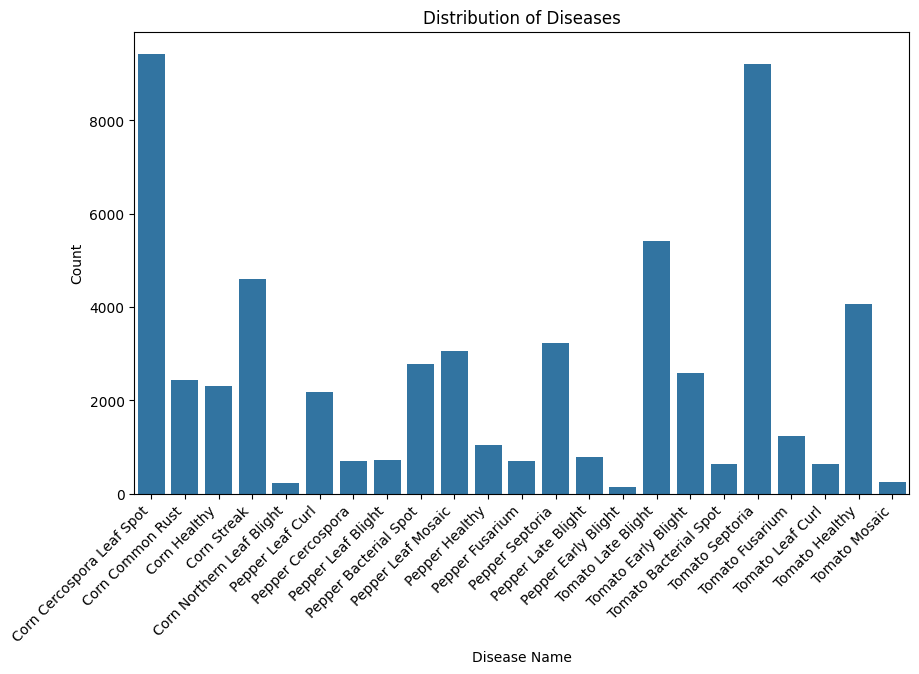

In [15]:
# Plot a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=filtered_df)
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Diseases')
plt.xlabel('Disease Name')
plt.ylabel('Count')

# Show the plot
plt.show()

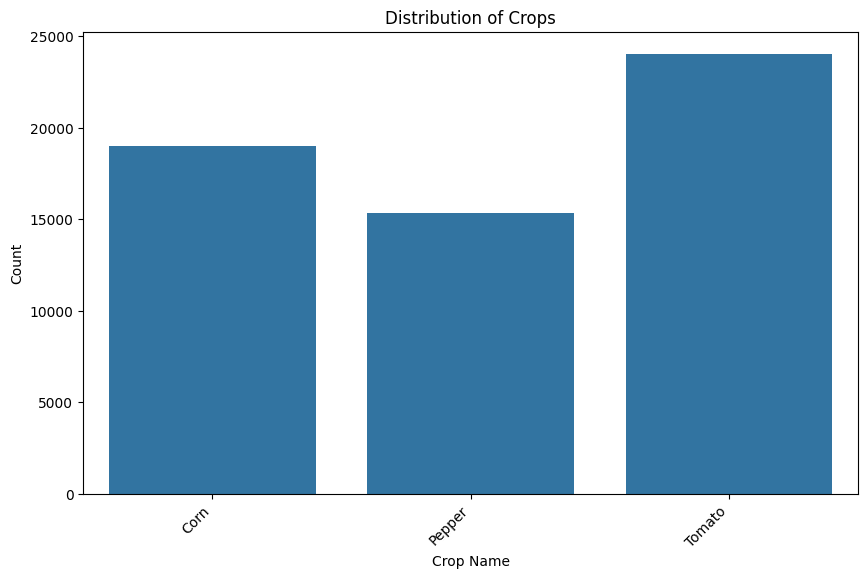

In [16]:
# Plot a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='crop', data=filtered_df)
# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Crops')
plt.xlabel('Crop Name')
plt.ylabel('Count')

# Show the plot
plt.show()

In [17]:
disease = data_df['class'].unique()
disease

array(['Corn Cercospora Leaf Spot', 'Corn Common Rust', 'Corn Healthy',
       'Corn Streak', 'Corn Northern Leaf Blight', 'Pepper Leaf Curl',
       'Pepper Cercospora', 'Pepper Leaf Blight', 'Pepper Bacterial Spot',
       'Pepper Leaf Mosaic', 'Pepper Healthy', 'Pepper Fusarium',
       'Pepper Septoria', 'Pepper Late Blight', 'Pepper Early Blight',
       'Tomato Late Blight', 'Tomato Early Blight',
       'Tomato Bacterial Spot', 'Tomato Septoria', 'Tomato Fusarium',
       'Tomato Leaf Curl', 'Tomato Healthy', 'Tomato Mosaic'],
      dtype=object)

In [18]:
def class_text_to_int(row_label, label_map):
    return label_map[row_label]

def create_label_map(disease_list):
    label_map = {}
    for index, disease in enumerate(disease_list):
        label_map[disease] = index + 1  # Start labels from 1
    return label_map

labels_map = create_label_map(disease)

def save_label_map_to_json(label_map, output_dir):
    label_map_path = os.path.join(output_dir, 'label_map.json')
    with open(label_map_path, 'w') as label_map_file:
        json.dump(label_map, label_map_file)

save_label_map_to_json(labels_map, './input')

In [19]:
# split the data into three
train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

# Split the dataset into train, test, and validation sets
train_data, temp_data = train_test_split(data_df, test_size=(1 - train_ratio))
test_data, val_data = train_test_split(temp_data, test_size=(val_ratio / (1 - train_ratio)))



In [20]:
train_data.head(12)

,filename,width,height,crop,class,xmin,ymin,xmax,ymax,image_path
55434,2N8A2488.JPG,1920,1280,Tomato,Tomato Late Blight,574.274899,613.708375,768.482503,782.552977,input/Tomato\Tomato__Septoria\2N8A2488.JPG
8054,20230526_114423(1).jpg,4080,1836,Corn,Corn Healthy,2363.605870,1317.085889,2916.729560,1707.663529,input/Corn\Corn__Cercospora_Leaf_Spot\20230526...
9881,20230526_102928.jpg,4080,1836,Corn,Corn Common Rust,1065.692626,386.556374,1366.560992,948.884093,input/Corn\Corn__Common_Rust\20230526_102928.jpg
13546,2N8A0779.JPG,1920,1280,Corn,Corn Streak,1551.651139,147.236025,1606.506211,605.502070,input/Corn\Corn__Streak\2N8A0779.JPG
23806,20230522_091914.jpg,4080,3060,Pepper,Pepper Leaf Curl,954.041570,854.194366,1436.460739,1419.501091,input/Pepper\Pepper__Leaf_Curl\20230522_091914...
54602,2N8A0766.JPG,1920,1280,Tomato,Tomato Septoria,592.603520,392.500000,673.027950,483.990683,input/Tomato\Tomato__Septoria\2N8A0766.JPG
12905,20230526_115624.jpg,4080,1836,Corn,Corn Healthy,871.674707,1407.181183,1484.658856,1615.242439,input/Corn\Corn__Healthy\20230526_115624.jpg
28059,20230518_144547.jpg,4080,3060,Pepper,Pepper Bacterial Spot,1936.556065,1091.257551,2031.610340,1164.074620,input/Pepper\Pepper__Mosaic\20230518_144547.jpg
36664,IMG_4614.jpeg,4032,3024,Tomato,Tomato Early Blight,1615.647070,1912.370366,1717.187829,1995.223572,input/Tomato\Tomato__Early_Blight\IMG_4614.jpeg
2492,20230525_090026.jpg,4080,1836,Corn,Corn Cercospora Leaf Spot,1519.943662,1696.647887,1609.014085,1742.619718,input/Corn\Corn__Cercospora_Leaf_Spot\20230525...


In [21]:
# save the train, test and validate split to seperate scv files
train_csv_path = 'input/train_data.csv'
test_csv_path = 'input/test_data.csv'
val_csv_path = 'input/val_data.csv'

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)
val_data.to_csv(val_csv_path, index=False)

In [22]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
validate_df = pd.read_csv(val_csv_path)

In [23]:
def resize_and_write_image(image_path, bboxes, labels, width=640, height=640, output_directory='dataset'):
    """
        This function takes in some input parameters for each row of a a dataframe
        It resize the image and normalize the bounding boxes and its positions
        It then writes the resized image to a new location and return the path of the new image
        and the normalized coordingates of the bounding boxes. the new bounding boxes are represented with 
        x1,y1,x2,y2 as it was originally xmin, ymin, xmax, ymax
    """
    image_format = 'jpg'
    
    # Generate a random filename using UUID
    random_filename = str(uuid.uuid4())
    
    # Create Chitra object from the original image
    img = Chitra(image_path, bboxes, labels)
    # Resize the image and update the bounding boxes
    img.resize_image_with_bbox((width, height))

    # Define the new image path by replacing "input" with "dataset" and using the random filename
    new_image_path = os.path.join(output_directory, random_filename + f'.{image_format}')
    # new_image_ = os.path.join(output_directory, os.path.relpath(image_path, 'input'))

    # Create the directory structure if it doesn't exist
    os.makedirs(os.path.dirname(new_image_path), exist_ok=True)

    img.image.save(fp=new_image_path)
    x1, y1, x2, y2 = img.bboxes[0].x1, img.bboxes[0].y1, img.bboxes[0].x2, img.bboxes[0].y2
    return random_filename + f'.{image_format}', new_image_path, x1, y1, x2, y2

In [27]:
validate_df['fname'], validate_df['img_path'], validate_df['x1'], validate_df['y1'], validate_df['x2'], validate_df['y2'] = zip(
        *validate_df.apply(
            lambda row: resize_and_write_image(
                row['image_path'], 
                [(row['xmin'], row['ymin'], row['xmax'], row['ymax'])], 
                [row['class']],
                width=640,
                height=640,
                output_directory=f"{output_directory}/validate"
                ), 
                axis=1
            )
        )

validate_df.to_csv('dataset/validate_labels.csv', index=False)

In [28]:
test_df['fname'], test_df['img_path'], test_df['x1'], test_df['y1'], test_df['x2'], test_df['y2'] = zip(
        *test_df.apply(
            lambda row: resize_and_write_image(
                row['image_path'], 
                [(row['xmin'], row['ymin'], row['xmax'], row['ymax'])],
                [row['class']], 
                width=640,
                height=640,
                output_directory=f"{output_directory}/test"
                ), 
                axis=1
            )
        )

test_df.to_csv('dataset/test_labels.csv', index=False) 

In [29]:
train_df['fname'], train_df['img_path'], train_df['x1'], train_df['y1'], train_df['x2'], train_df['y2'] = zip(
        *train_df.apply(
            lambda row: resize_and_write_image(
                row['image_path'], 
                [(row['xmin'], row['ymin'], row['xmax'], row['ymax'])],
                [row['class']], 
                width=640, 
                height=640,
                output_directory=f"{output_directory}/train"
                ), 
                axis=1
            )
        )

train_df.to_csv('dataset/train_labels.csv', index=False)

In [30]:
new_train_df = pd.read_csv('dataset/train_labels.csv')
new_test_df = pd.read_csv('dataset/test_labels.csv')
new_validate_df = pd.read_csv('dataset/validate_labels.csv')

In [31]:
new_train_df.head()

,filename,width,height,crop,class,xmin,ymin,xmax,ymax,image_path,fname,img_path,x1,y1,x2,y2
0,2N8A2488.JPG,1920,1280,Tomato,Tomato Late Blight,574.274899,613.708375,768.482503,782.552977,input/Tomato\Tomato__Septoria\2N8A2488.JPG,e701b2d9-d9ef-49dd-a9b2-067ac10dff12.jpg,dataset/train\e701b2d9-d9ef-49dd-a9b2-067ac10d...,191.42496,306.85420,256.16083,391.27650
1,20230526_114423(1).jpg,4080,1836,Corn,Corn Healthy,2363.605870,1317.085889,2916.729560,1707.663529,input/Corn\Corn__Cercospora_Leaf_Spot\20230526...,ee11488a-d7c4-4426-898b-0153fe55d82b.jpg,dataset/train\ee11488a-d7c4-4426-898b-0153fe55...,370.76172,459.11493,457.52620,595.26400
2,20230526_102928.jpg,4080,1836,Corn,Corn Common Rust,1065.692626,386.556374,1366.560992,948.884093,input/Corn\Corn__Common_Rust\20230526_102928.jpg,8c38b101-19ed-4353-b518-63e1128fc5b7.jpg,dataset/train\8c38b101-19ed-4353-b518-63e1128f...,167.16748,134.74731,214.36250,330.76570
3,2N8A0779.JPG,1920,1280,Corn,Corn Streak,1551.651139,147.236025,1606.506211,605.502070,input/Corn\Corn__Streak\2N8A0779.JPG,627ce1e3-0354-4713-9f12-3d2db183e3e0.jpg,dataset/train\627ce1e3-0354-4713-9f12-3d2db183...,517.21704,73.61801,535.50210,302.75104
4,20230522_091914.jpg,4080,3060,Pepper,Pepper Leaf Curl,954.041570,854.194366,1436.460739,1419.501091,input/Pepper\Pepper__Leaf_Curl\20230522_091914...,fe203180-5056-479c-abe4-e9d4c613dc01.jpg,dataset/train\fe203180-5056-479c-abe4-e9d4c613...,149.65358,178.65503,225.32716,296.88910


In [32]:
new_test_df.head()

,filename,width,height,crop,class,xmin,ymin,xmax,ymax,image_path,fname,img_path,x1,y1,x2,y2
0,IMG_2970.jpeg,4032,3024,Corn,Corn Streak,1841.291921,2836.457654,2224.546507,3024.000000,input/Corn\Corn__Streak\IMG_2970.jpeg,82310e7f-e7b2-482f-bcd1-018c67c988dd.jpg,dataset/test\82310e7f-e7b2-482f-bcd1-018c67c98...,292.26855,600.30853,353.10260,640.00000
1,IMG_5646.jpeg,4032,3024,Corn,Corn Cercospora Leaf Spot,1406.371834,1248.398356,1442.933843,1272.243379,input/Corn\Corn__Streak\IMG_5646.jpeg,b8a7ba1d-8539-4382-8114-7f5089b575a2.jpg,dataset/test\b8a7ba1d-8539-4382-8114-7f5089b57...,223.23363,264.21130,229.03711,269.25787
2,20230518_124402.jpg,4080,3060,Pepper,Pepper Leaf Curl,2662.669978,1965.493460,3136.186851,2511.085513,input/Pepper\Pepper__Leaf_Curl\20230518_124402...,06ce713c-395f-4c61-8cef-57fa35e3a162.jpg,dataset/test\06ce713c-395f-4c61-8cef-57fa35e3a...,417.67370,411.08362,491.95087,525.19434
3,20230525_111504.jpg,4080,1836,Corn,Corn Common Rust,2674.073053,740.822837,3135.217092,1019.175057,input/Corn\Corn__Cercospora_Leaf_Spot\20230525...,dc48cba8-d584-4e3c-8dd7-02249cd2cae6.jpg,dataset/test\dc48cba8-d584-4e3c-8dd7-02249cd2c...,419.46243,258.23890,491.79874,355.26797
4,IMG_5995.jpeg,4032,3024,Tomato,Tomato Late Blight,1570.339991,693.189037,1705.466418,904.168033,input/Tomato\Tomato__Late_Blight\IMG_5995.jpeg,293433c3-d9cd-41c1-96ef-f6f7496ed8c1.jpg,dataset/test\293433c3-d9cd-41c1-96ef-f6f7496ed...,249.26031,146.70668,270.70895,191.35832


In [33]:
new_validate_df.head()

,filename,width,height,crop,class,xmin,ymin,xmax,ymax,image_path,fname,img_path,x1,y1,x2,y2
0,20230519_112311.jpg,4080,3060,Pepper,Pepper Bacterial Spot,1962.898849,1861.849507,2080.025493,1967.554276,input/Pepper\Pepper__Cercospora_Leaf_Spot\2023...,e4cb0aa8-2265-464b-b45b-0482f68c1f8b.jpg,dataset/validate\e4cb0aa8-2265-464b-b45b-0482f...,307.905700,389.40643,326.27850,411.51462
1,2N8A2503.JPG,1920,1280,Pepper,Pepper Septoria,847.172131,587.757611,986.153396,623.823185,input/Pepper\Pepper__Septoria\2N8A2503.JPG,e38b19ee-3c97-4ce6-9d12-24de77f5d496.jpg,dataset/validate\e38b19ee-3c97-4ce6-9d12-24de7...,282.390720,293.87880,328.71780,311.91160
2,IMG_6453.jpeg,4032,3024,Pepper,Pepper Septoria,144.613636,673.478206,697.745116,1148.960922,input/Pepper\Pepper__Septoria\IMG_6453.jpeg,befa8b69-83e7-41c2-aa1d-7e51e3fc9d66.jpg,dataset/validate\befa8b69-83e7-41c2-aa1d-7e51e...,22.954544,142.53506,110.75319,243.16634
3,2010-01-01%2000.11.25.jpg,1920,2560,Pepper,Pepper Cercospora,1424.435369,2298.349308,1485.969460,2365.804047,input/Pepper\Pepper__Cercospora_Leaf_Spot\2010...,03dc4cd7-4d50-4d52-9106-0207d88bf0ed.jpg,dataset/validate\03dc4cd7-4d50-4d52-9106-0207d...,474.811830,574.58734,495.32315,591.45100
4,IMG_6195.jpeg,4032,3024,Tomato,Tomato Late Blight,275.576602,937.959529,375.621598,1062.350410,input/Tomato\Tomato__Late_Blight\IMG_6195.jpeg,36362e77-549b-4815-8000-0aade6f2e01b.jpg,dataset/validate\36362e77-549b-4815-8000-0aade...,43.742317,198.50996,59.62248,224.83609
